# ResNet50으로 Custom Data(Image) 분류

### 모델 새로 정의

내용은 vGG16과 동일하다.


In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'dental_image/train'
validation_dir = 'dental_image/test'
batch_size = 2  # 메모리가 충분하면 32
image_size = 224

# 학습에 사용될 이미지 데이터 생성기
train_datagen = ImageDataGenerator(
        rotation_range=180, # 회전 쵀대 20도
        width_shift_range=0.2, # 좌우 이동
        height_shift_range=0.2, # 상하 이동
        horizontal_flip=True, # 좌우 반전
        vertical_flip=True, # 상하 반전
)
 
# 검증에 사용될 이미지 데이터 생성기
validation_datagen = ImageDataGenerator()
 
# 학습에 사용될 데이터 생성기  
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
)

# 검증에 사용될 데이터 생성기
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
)

class_num=len(train_generator.class_indices)
custom_labels = list(validation_generator.class_indices.keys())

Found 150 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [3]:
#from keras.applications import vgg16
from keras.applications import resnet50

#conv_layers = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
conv_layers = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
conv_layers.summary()

for layer in conv_layers.layers:
    layer.trainable = False

model = models.Sequential()

model.add(conv_layers)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(class_num, activation='softmax'))
model.summary()

# vgg16_model_path = 'new_trained_from_vgg16.h5'
resnet50_model_path = 'model/new_trained_from_resnet50.h5'

# model.save(vgg16_model_path)
model.save(resnet50_model_path)

C:\Users\ckkim\.conda\envs\tf2\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              102761472 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 126,352,259
Trainable params: 102,764,547
Non-trainable params: 23,587,712
_________________________________________________________________


## 모델 학습

In [4]:
from keras.models import load_model

#model = load_model(vgg16_model_path)
#model = load_model(resnet50_model_path)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

#model.save(vgg16_model_path)
model.save(resnet50_model_path)

Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[1,256,56,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node SquaredDifference_56 (defined at C:\Users\ckkim\.conda\envs\tf2\lib\site-packages\keras\backend\tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_15701]

Function call stack:
keras_scratch_graph


## 학습 중의 로스와 정확도 보기


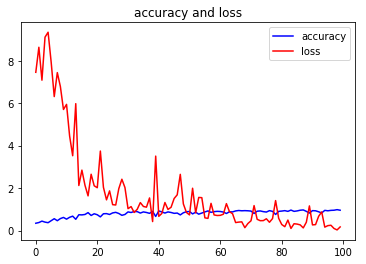

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))

fig, ax0 = plt.subplots(figsize=(12,8))
ax1 = ax0.twinx()
ax0.plot(epochs, loss, c="blue", label='Trainset_loss')
ax0.set_ylabel('loss')
ax1.plot(epochs, acc, c="darkgreen", label='Trainset_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper left')
ax1.legend(loc='lower left')
plt.grid()
plt.show()

## 새로 학습된 모델로 분류 실행

학습된 모델 파일을 읽어서 분류를 실행한다.


In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#from keras.applications import vgg16
from keras.applications import resnet50
from IPython.display import display
import numpy as np

def predict_custom_resnet50(model, filename) :
    image = load_img(filename)
    display(image)

    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, 224, 224, 3))

    #  image = vgg16.preprocess_input(image)
    image = resnet50.preprocess_input(image)

    yhat = model.predict(image)

    # 최대 출력 인덱스를 구한다.
    idx=np.argmax(yhat[0])

    # 커스텀 레이블을 출력한다.
    print('%s (%.2f%%)' % (custom_labels[idx], yhat[0][idx]*100))


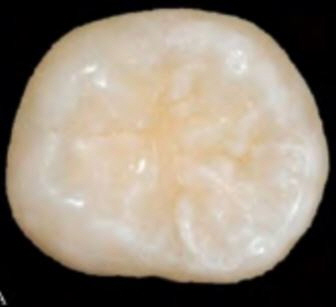

healthy (100.00%)


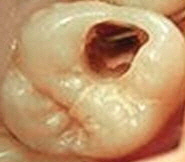

decayed (100.00%)


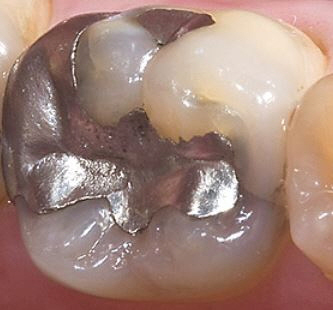

decayed (99.99%)


In [11]:
from keras.models import load_model

model = load_model(resnet50_model_path)
  
files = [
    'dental_image/test/healthy/1.jpg',
    'dental_image/test/decayed/101.jpg',
    'dental_image/test/cured/301.jpg'
        ]

  
for file in files :
    predict_custom_resnet50(model, file)     
